In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import multiprocessing
print("num of cpus:", multiprocessing.cpu_count())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
num of cpus: 2


NameError: ignored

In [ ]:
#### Data preperation
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

folder_path = '/content/drive/MyDrive/TDS_data_15000'

#Load and preprocess the data
def load_data(folder_path):
  """
  """
  data = {}
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path):
          with open(file_path, 'r') as file:
              df1 = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, squeeze = True)
              #df1 = df1.fillna(df1.mean()) # Replace NaN with column average
              data[filename] = df1
    
              num_datapts = len(df1["des_flux"])
  # Combine all the data into a single dataframe
  df = pd.concat(data.values())

  return df, num_datapts

df, num_datapts = load_data(folder_path)

des_flux=df['des_flux']
des_flux=des_flux.tolist()
num_files=int(len(des_flux)/num_datapts) 
des_flux=np.reshape(des_flux, [num_files, num_datapts])
    # This assumes that all spectra in the dataset/folder have the same
    # amount of datapoints
display(des_flux)
#print(type(des_flux[0]), des_flux.shape)

detrap_en=df['detrap_en']
detrap_en=detrap_en.dropna()
detrap_en=detrap_en.tolist()
num_files=int(len(detrap_en)/4)
detrap_en=np.reshape(detrap_en, [num_files, 4])
#print(detrap_en, detrap_en.shape)

def_conc=df['def_conc']
def_conc=def_conc.dropna()
def_conc=def_conc.tolist()
num_files=int(len(def_conc)/4)
def_conc=np.reshape(def_conc, [num_files, 4])
#print(def_conc, def_conc.shape)

def_param = np.concatenate([detrap_en, def_conc], axis=1)
print(def_param.shape)

# Split the data into train and test sets
X_train, X_test= train_test_split(des_flux, test_size=0.1, random_state=42)
y_train, y_test = train_test_split(def_param, test_size=0.1, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Normalize the data
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_norm = scaler.fit_transform(X_train.reshape(-1, 1))
X_test_norm = scaler.transform(X_test.reshape(-1, 1))

#Reshape data for model input
#Checked to make sure the time-series nature of the X_train, X_test is intact, can double check
#By calling an array and comparing with a .csv file
X_train_transform = np.reshape(X_train_norm, (X_train.shape))
print(X_train_transform.shape)

X_test_transform = np.reshape(X_test_norm, (X_test.shape))



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import plot_tree
from joblib import Parallel, delayed, parallel_backend#, print_progress

### Defining a function to train a random forest with gridsearchcv
def train_rf(X_train, y_train, X_test, y_test, i, n_estimators=None, max_depth=None):
    """Trains a random forest regression model using preprocessed training data.
    Without specifying parameters, will preform a gridsearch across a range.
    """
    rfr = RandomForestRegressor() 
    folds = KFold(n_splits=10, shuffle=True)
    rfr_y_pred = [] 
    if n_estimators is not None and max_depth is not None:
        train_rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
        train_rf.fit(X_train, y_train)
        rfr_y_pred = train_rf.predict(X_test)
    else:
        param_grid= {"n_estimators": range(1,100), "max_depth": range(1,50)}
        with parallel_backend('threading', n_jobs=-1): # threading to avoid nested loop error
            train_rf = GridSearchCV(rfr, param_grid, 
                           return_train_score=True,
                           scoring="neg_mean_squared_error",
                            cv=folds, n_jobs=20)
        train_rf.fit(X_train, y_train)
            #fitting_models = Parallel()(delayed(rf_gcv.fit)(X, y) for X, y in zip(X for i in range(num_models), y_list))
            
        print(train_rf.best_params_)
        print(train_rf.best_score_)
        
        # Predict based on test data 
        train_rf = train_rf.best_estimator_
        rfr_y_pred = train_rf.predict(X_test)
    
        # Calculate the mse 
    mse = mean_squared_error(y_test, rfr_y_pred)

    # Print the MSE for this model
    #print(f"Model {i} MSE: {mse}")

    return train_rf, rfr_y_pred


### 0.3K/s, 15K dataset without noise

In [ ]:
%%time
# https://joblib.readthedocs.io/en/latest/parallel.html
num_models = 5 # set number of models to run in parallel

with parallel_backend('multiprocessing', n_jobs=-1): # multiprocessing for outloop, prevents the parallel nested loop error
    models = Parallel()(delayed(train_rf)(X_train_transform, y_train, X_test_transform, y_test, i, n_estimators=49, max_depth=7) for i in range(num_models))

    # best_params = {'max_depth': 7, 'n_estimators': 49} 
    
# Combines predictions from all the models by taking the mean
y_pred = [model[1] for model in models]
y_pred_mean = np.mean(y_pred, axis=0)

# Calculates final MSE
mse = mean_squared_error(y_test, y_pred_mean)

# Prints final MSE
print(f"Final Test MSE = {mse}")


Final Test MSE = 0.003916376700614401
CPU times: user 2.5 s, sys: 499 ms, total: 3 s
Wall time: 7min 49s


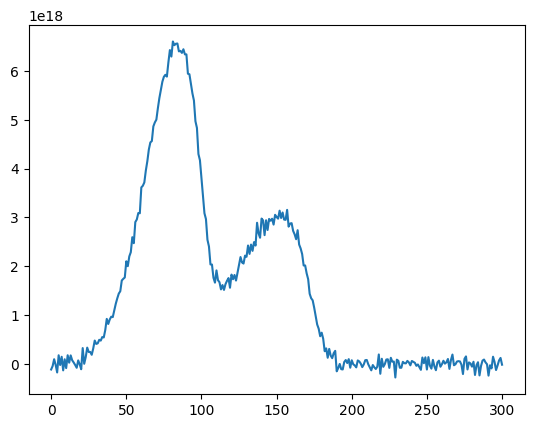

In [ ]:
### Adding noise
import matplotlib.pyplot as plt

spect_wnoise=[]
noise_array=[]
sigma_list=[]
for n in np.arange(0, len(des_flux)):
    sigma_rand = np.random.uniform(1E14, 1E17)
    for i, k in enumerate(des_flux[n]):
        spect_wnoise.append(np.random.normal(k, sigma_rand))
    sigma_list.append(str(sigma_rand))
    noise_array.append(spect_wnoise)
    spect_wnoise=[]
#plt.plot(noise_array[4])
#plt.show()


In [ ]:
# Setting test and train data using noisy spectra
X_train, X_test= train_test_split(noise_array, test_size=0.1, random_state=42)
y_train, y_test = train_test_split(def_param, test_size=0.1, random_state=42)


# Normalize the data
# Change lists into array
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_norm = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_norm = scaler.transform(np.array(X_test).reshape(-1, 1))

#Reshape data for model input
#Checked to make sure the time-series nature of
#the X_train, X_test is intact, can double check
#By calling an array and comparing with a .csv file
X_train_transform = np.reshape(X_train_norm, (np.array(X_train).shape[0],-1))
print(X_train_transform.shape)

X_test_transform = np.reshape(X_test_norm, (np.array(X_test).shape[0],-1))
print(X_test_transform.shape)


(13500, 301)
(1500, 301)


### 0.3K/s, 15K dataset with noise

In [ ]:
%%time
num_models = 5 # set number of models to run in parallel

with parallel_backend('multiprocessing', n_jobs=-1): # multiprocessing for outloop, prevents the parallel nested loop error
    noise_models = Parallel()(delayed(train_rf)(X_train_transform, y_train, X_test_transform, y_test, i, n_estimators=49, max_depth=7) for i in range(num_models))

# Combines predictions from all the models by taking the mean
y_pred = [model[1] for model in noise_models]
y_pred_mean = np.mean(y_pred, axis=0)

# Prints final MSE
mse = mean_squared_error(y_test, y_pred_mean)
print(f"Final MSE = {mse}")

Final MSE = 0.004264739521846113
CPU times: user 3.11 s, sys: 576 ms, total: 3.69 s
Wall time: 8min 56s


In [ ]:
### Basic PLSR
from sklearn.cross_decomposition import PLSRegression
plsr = PLSRegression(n_components=2)
plsr.fit(X_train_transform, y_train)
X_train_pls = plsr.transform(X_train_transform)
pls_pred = plsr.predict(X_test_transform)
# Calculates mse 
mse = mean_squared_error(y_test, pls_pred)
print(f"MSE = {mse}")

MSE = 0.008725202455676108
